# Group 21 - We're Kenough

- Angelica Ricci: 105181
- Mattia Milone: 105633
- Michele Lamon: 105251

# Long notebook

## Importing all the libraries

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from datetime import datetime

import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
from catboost import Pool, cv
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, KFold, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

import warnings
import os
import re
import sys
from skopt import gp_minimize, space, BayesSearchCV
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

## Generic Functions

In [20]:
def plot_pred(pred_list, name_list, a1=0, a2=2160):
    new_dataframe = pd.DataFrame()

    for i in range(len(pred_list)):
        new_dataframe[name_list[i]] = pred_list[i]['values']

    plt.figure(figsize=(20,9))

    for i in range(len(pred_list)):
        new_dataframe[name_list[i]][a1:a2].plot(label=name_list[i])

    plt.legend()
    plt.show()

In [21]:
def pred_to_df(array_pred, squared=False):
    if squared==True:
        array_pred = array_pred**2

    df_predicitons = pd.DataFrame(array_pred)
    df_predicitons = df_predicitons.applymap(lambda x: max(0, x))
    df_predicitons.iloc[:,0] = df_predicitons.iloc[:,0].apply(lambda x: 0 if 0 <= x <= 1 else x)
    df_predicitons.rename(columns={df_predicitons.columns[0]: 'values'}, inplace=True)
    df_predicitons = df_predicitons.rename_axis('id')
    return df_predicitons

In [22]:
def merge_with_slided(dataframe, merging_dataframe):
    
    new_dataframe = pd.DataFrame()
    new_dataframe['val1'] = dataframe['values']
    
    new_dataframe['val2'] = merging_dataframe['values']
    new_dataframe['max'] = new_dataframe[['val1','val2']].max(axis=1)
    new_dataframe['values'] = np.where(new_dataframe['val1'] < 3000, new_dataframe['val1'], new_dataframe['max'])
    only_A=new_dataframe.copy()[:720]
    only_B_C=new_dataframe.copy()[720:]
    only_B_C['values'] = np.where(only_B_C['val1'] < 550, only_B_C['val1'], only_B_C['max'])
    new_dataframe = pd.concat([only_A, only_B_C])['values']
    
    return pred_to_df(new_dataframe)

In [23]:
def merge_with_slided_A(dataframe, merging_dataframe):
    
    new_dataframe = pd.DataFrame()
    new_dataframe['val1'] = dataframe['values']
    
    new_dataframe['val2'] = merging_dataframe['values']
    new_dataframe['max'] = new_dataframe[['val1','val2']].max(axis=1)
    new_dataframe['values'] = np.where(new_dataframe['val1'] < 3000, new_dataframe['val1'], new_dataframe['max'])
    only_A=new_dataframe.copy()[:720]
    only_B_C=new_dataframe.copy()[720:]
    new_dataframe = pd.concat([only_A, only_B_C])['values']
    
    return pred_to_df(new_dataframe)

## Uploading the data

In [24]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

In [25]:
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

In [26]:
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

In [27]:
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

In [28]:
test2 = pd.read_csv('test.csv')
test2['time'] = pd.to_datetime(test2['time'])

## Domain Knowledge

In this project, the solar energy produced by the panels installed in three different buildings (A, B and C, respectively) has to be predicted. 

Each 'train' dataset contains the 'pv_measurement' feature, which is the target feature to be predicted; moreover, 'train_estimated', 'train_observed' and 'test_esitmated' dataframes also contain the weather conditions/predictions of 45 different atmospheric events (such as direct radiation, humidity, pressure, temperature and so on). Of course, the 'test_estimated' is used to test the trained model/models and create the final predictions.

Each weather observation is reported every 15 minutes, while the 'pv_measurement' is reported hourly: this means that in the feature engineering section, it is extremely important to deal with this problem. As a matter of fact, the group has decided to take the median of every four observations, which can better deal with outliers (with respect to the mean).

An accurate hourly prediction of the future solar energy production in the subsequent 30 days is required: the more accurate the prediction will be, the more the energy efficiency will improve and the general costs will be reduced.

A lot of feature engineering is needed, with the aim of improving the performance of the model. New temporal features are created (hour, month, season, observed/estimated among others), as well as interaction features between the already available ones. For models like xgboost, the Standard Scaler operation shows an improvement over the MAE, while for others such as light gbm, it is useful to transform the y feature (the group tried both the logarithmic and the square root transformation and declared that the latter is better than the former).

**Economic aspects**

The importance of accurate predictions may affect two significant aspects:

- *Reduction of the costs*, since the buildings can use more of its self-generated solar power and reduce their dependency on conventional power sources;
- *Environmental benefits*, which include the minimization of the carbon footprint of the buildings, leading to a green and sustainable environment.

## Preparation of the data and cleaning up the features

In [29]:
train_a['time'] = pd.to_datetime(train_a['time'])
train_b['time'] = pd.to_datetime(train_b['time'])
train_c['time'] = pd.to_datetime(train_c['time'])

X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])

X_test_estimated_a['date_forecast'] = pd.to_datetime(X_test_estimated_a['date_forecast'])
X_test_estimated_b['date_forecast'] = pd.to_datetime(X_test_estimated_b['date_forecast'])
X_test_estimated_c['date_forecast'] = pd.to_datetime(X_test_estimated_c['date_forecast'])

In [30]:
X_train_estimated_a['forecast_age'] = (X_train_estimated_a['date_forecast']-X_train_estimated_a['date_calc']).dt.seconds/3600
del X_train_estimated_a['date_calc']
X_test_estimated_a['forecast_age'] = (X_test_estimated_a['date_forecast']-X_test_estimated_a['date_calc']).dt.seconds/3600
del X_test_estimated_a['date_calc']

X_train_estimated_b['forecast_age'] = (X_train_estimated_b['date_forecast']-X_train_estimated_b['date_calc']).dt.seconds/3600
del X_train_estimated_b['date_calc']
X_test_estimated_b['forecast_age'] = (X_test_estimated_b['date_forecast']-X_test_estimated_b['date_calc']).dt.seconds/3600
del X_test_estimated_b['date_calc']

X_train_estimated_c['forecast_age'] = (X_train_estimated_c['date_forecast']-X_train_estimated_c['date_calc']).dt.seconds/3600
del X_train_estimated_c['date_calc']
X_test_estimated_c['forecast_age'] = (X_test_estimated_c['date_forecast']-X_test_estimated_c['date_calc']).dt.seconds/3600
del X_test_estimated_c['date_calc']

In [31]:
X_train_observed_a.set_index('date_forecast', inplace=True)
X_train_observed_b.set_index('date_forecast', inplace=True)
X_train_observed_c.set_index('date_forecast', inplace=True)

X_train_estimated_a.set_index('date_forecast', inplace=True)
X_train_estimated_b.set_index('date_forecast', inplace=True)
X_train_estimated_c.set_index('date_forecast', inplace=True)

X_test_estimated_a.set_index('date_forecast', inplace=True)
X_test_estimated_b.set_index('date_forecast', inplace=True)
X_test_estimated_c.set_index('date_forecast', inplace=True)

In [32]:
X_train_observed_a['sensor_A'] = 1
X_train_observed_a['sensor_B'] = 0
X_train_observed_a['sensor_C'] = 0
X_train_observed_a['month'] = X_train_observed_a.index.strftime('%m')
X_train_observed_a['hour'] = X_train_observed_a.index.strftime('%H')
X_train_observed_a['forecast_age'] = 0
X_train_observed_a['is_obv'] = 1

X_train_observed_b['sensor_A'] = 0
X_train_observed_b['sensor_B'] = 1
X_train_observed_b['sensor_C'] = 0
X_train_observed_b['month'] = X_train_observed_b.index.strftime('%m')
X_train_observed_b['hour'] = X_train_observed_b.index.strftime('%H')
X_train_observed_b['forecast_age'] = 0
X_train_observed_b['is_obv'] = 1

X_train_observed_c['sensor_A'] = 0
X_train_observed_c['sensor_B'] = 0
X_train_observed_c['sensor_C'] = 1
X_train_observed_c['month'] = X_train_observed_c.index.strftime('%m')
X_train_observed_c['hour'] = X_train_observed_c.index.strftime('%H')
X_train_observed_c['forecast_age'] = 0
X_train_observed_c['is_obv'] = 1

In [33]:
X_train_estimated_a['sensor_A'] = 1
X_train_estimated_a['sensor_B'] = 0
X_train_estimated_a['sensor_C'] = 0
X_train_estimated_a['month'] = X_train_estimated_a.index.strftime('%m')
X_train_estimated_a['hour'] = X_train_estimated_a.index.strftime('%H')
X_train_estimated_a['is_obv'] = 0

X_train_estimated_b['sensor_A'] = 0
X_train_estimated_b['sensor_B'] = 1
X_train_estimated_b['sensor_C'] = 0
X_train_estimated_b['month'] = X_train_estimated_b.index.strftime('%m')
X_train_estimated_b['hour'] = X_train_estimated_b.index.strftime('%H')
X_train_estimated_b['is_obv'] = 0

X_train_estimated_c['sensor_A'] = 0
X_train_estimated_c['sensor_B'] = 0
X_train_estimated_c['sensor_C'] = 1
X_train_estimated_c['month'] = X_train_estimated_c.index.strftime('%m')
X_train_estimated_c['hour'] = X_train_estimated_c.index.strftime('%H')
X_train_estimated_c['is_obv'] = 0

In [34]:
X_test_estimated_a['sensor_A'] = 1
X_test_estimated_a['sensor_B'] = 0
X_test_estimated_a['sensor_C'] = 0
X_test_estimated_a['month'] = X_test_estimated_a.index.strftime('%m')
X_test_estimated_a['hour'] = X_test_estimated_a.index.strftime('%H')
X_test_estimated_a['is_obv'] = 0

X_test_estimated_b['sensor_A'] = 0
X_test_estimated_b['sensor_B'] = 1
X_test_estimated_b['sensor_C'] = 0
X_test_estimated_b['month'] = X_test_estimated_b.index.strftime('%m')
X_test_estimated_b['hour'] = X_test_estimated_b.index.strftime('%H')
X_test_estimated_b['is_obv'] = 0

X_test_estimated_c['sensor_A'] = 0
X_test_estimated_c['sensor_B'] = 0
X_test_estimated_c['sensor_C'] = 1
X_test_estimated_c['month'] = X_test_estimated_c.index.strftime('%m')
X_test_estimated_c['hour'] = X_test_estimated_c.index.strftime('%H')
X_test_estimated_c['is_obv'] = 0

In [35]:
X_train_observed_a[["month", "hour"]] = X_train_observed_a[["month", "hour"]].apply(pd.to_numeric)
X_train_estimated_a[["month", "hour"]] = X_train_estimated_a[["month", "hour"]].apply(pd.to_numeric)
X_test_estimated_a[["month", "hour"]] = X_test_estimated_a[["month", "hour"]].apply(pd.to_numeric)

X_train_observed_b[["month", "hour"]] = X_train_observed_b[["month", "hour"]].apply(pd.to_numeric)
X_train_estimated_b[["month", "hour"]] = X_train_estimated_b[["month", "hour"]].apply(pd.to_numeric)
X_test_estimated_b[["month", "hour"]] = X_test_estimated_b[["month", "hour"]].apply(pd.to_numeric)

X_train_observed_c[["month", "hour"]] = X_train_observed_c[["month", "hour"]].apply(pd.to_numeric)
X_train_estimated_c[["month", "hour"]] = X_train_estimated_c[["month", "hour"]].apply(pd.to_numeric)
X_test_estimated_c[["month", "hour"]] = X_test_estimated_c[["month", "hour"]].apply(pd.to_numeric)

### Resampling the observations by taking the median

In [36]:
X_train_observed_a = X_train_observed_a.resample('H').median()
X_train_observed_b = X_train_observed_b.resample('H').median()
X_train_observed_c = X_train_observed_c.resample('H').median()
X_train_estimated_a = X_train_estimated_a.resample('H').median()
X_train_estimated_b = X_train_estimated_b.resample('H').median()
X_train_estimated_c = X_train_estimated_c.resample('H').median()
X_test_estimated_a = X_test_estimated_a.resample('H').median()
X_test_estimated_b = X_test_estimated_b.resample('H').median()
X_test_estimated_c = X_test_estimated_c.resample('H').median()

### Dealing with the stationary values

In [37]:
train_b_new = train_b.copy()

train_b_new['diff1'] = train_b_new['pv_measurement'] - train_b_new['pv_measurement'].shift(1)
train_b_new['diff3'] = train_b_new['pv_measurement'] - train_b_new['pv_measurement'].shift(3)
train_b_new['diff5'] = train_b_new['pv_measurement'] - train_b_new['pv_measurement'].shift(5)
train_b_new['diff7'] = train_b_new['pv_measurement'] - train_b_new['pv_measurement'].shift(7)
train_b_new['diff10'] = train_b_new['pv_measurement'] - train_b_new['pv_measurement'].shift(10)
train_b_new['diff15'] = train_b_new['pv_measurement'] - train_b_new['pv_measurement'].shift(15)

train_b_new['toDrop'] = ((train_b_new['diff1'] + train_b_new[
    'diff3'] + train_b_new['diff5'] + train_b_new['diff7'] + train_b_new['diff10'] + train_b_new['diff15']) == 0)

train_b_new = train_b_new[train_b_new['toDrop'] != True]
train_b_new = train_b_new.drop(columns=['diff1', 'diff3', 'diff5', 'diff7', 'diff10', 'diff15', 'toDrop'])

In [38]:
train_c_new = train_c.copy()

train_c_new['diff1'] = train_c_new['pv_measurement'] - train_c_new['pv_measurement'].shift(1)
train_c_new['diff3'] = train_c_new['pv_measurement'] - train_c_new['pv_measurement'].shift(3)
train_c_new['diff5'] = train_c_new['pv_measurement'] - train_c_new['pv_measurement'].shift(5)
train_c_new['diff7'] = train_c_new['pv_measurement'] - train_c_new['pv_measurement'].shift(7)
train_c_new['diff10'] = train_c_new['pv_measurement'] - train_c_new['pv_measurement'].shift(10)
train_c_new['diff15'] = train_c_new['pv_measurement'] - train_c_new['pv_measurement'].shift(15)

train_c_new['toDrop'] = ((train_c_new['diff1'] + train_c_new[
    'diff3'] + train_c_new['diff5'] + train_c_new['diff7'] + train_c_new['diff10'] + train_c_new['diff15']) == 0)

train_c_new = train_c_new[train_c_new['toDrop'] != True]
train_c_new = train_c_new.drop(columns=['diff1', 'diff3', 'diff5', 'diff7', 'diff10', 'diff15', 'toDrop'])

### Merging the train sets and creating the test set

In [39]:
y_train_observed_a = train_a.merge(X_train_observed_a, left_on='time', right_on='date_forecast', how='right')
y_train_observed_b = train_b_new.merge(X_train_observed_b, left_on='time', right_on='date_forecast', how='right')
y_train_observed_c = train_c_new.merge(X_train_observed_c, left_on='time', right_on='date_forecast', how='right')

y_train_obv = pd.concat([y_train_observed_a,y_train_observed_b,y_train_observed_c])

In [40]:
y_train_estimated_a = train_a.merge(X_train_estimated_a, left_on='time', right_on='date_forecast', how='right')
y_train_estimated_b = train_b_new.merge(X_train_estimated_b, left_on='time', right_on='date_forecast', how='right')
y_train_estimated_c = train_c_new.merge(X_train_estimated_c, left_on='time', right_on='date_forecast', how='right')

y_train_est = pd.concat([y_train_estimated_a,y_train_estimated_b,y_train_estimated_c])

In [41]:
test = pd.concat([X_test_estimated_a,X_test_estimated_b,X_test_estimated_c])

### NaN values

In [42]:
feature_with_nan_obv = [features for features in y_train_obv.columns if y_train_obv[features].isnull().sum()>1]
feature_with_nan_est =[features for features in y_train_est.columns if y_train_est[features].isnull().sum()>1]

In [43]:
del y_train_obv['snow_density:kgm3']
del y_train_est['snow_density:kgm3']
del test['snow_density:kgm3']

In [44]:
columns_to_delete=['ceiling_height_agl:m','snow_drift:idx','elevation:m','cloud_base_agl:m']
y_train_obv.drop(columns=columns_to_delete, inplace=True)
y_train_est.drop(columns=columns_to_delete, inplace=True)
test.drop(columns=columns_to_delete, inplace=True)

In [45]:
y_train_obv = y_train_obv.dropna()
y_train_est = y_train_est.dropna()

## Train and test sets

In [46]:
train=pd.concat([y_train_obv,y_train_est])
train=train.set_index('time')

In [47]:
col = test.pop('forecast_age')
test.insert(45, col.name, col)

In [48]:
train['day_of_week'] = train.index.dayofweek
test['day_of_week'] = test.index.dayofweek
train['day_of_year'] = train.index.dayofyear
test['day_of_year'] = test.index.dayofyear

In [49]:
season_mapping = {
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 4,
    11: 4,
    12: 1,
}

train['season'] = train['month'].map(season_mapping)
test['season'] = test['month'].map(season_mapping)

In [50]:
#One-Hot Encoding
train = pd.get_dummies(train, columns=['is_day:idx'])
test = pd.get_dummies(test, columns=['is_day:idx'])
train = pd.get_dummies(train, columns=['is_in_shadow:idx'])
test = pd.get_dummies(test, columns=['is_in_shadow:idx'])

In [51]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [52]:
X_train = train.loc[:, train.columns != "pv_measurement"]
y_train = train['pv_measurement']

In [53]:
# Create cyclical features for day of the week
X_train['day_of_week_sin'] = np.sin(2 * np.pi * X_train['day_of_week'] / 7)
X_train['day_of_week_cos'] = np.cos(2 * np.pi * X_train['day_of_week'] / 7)

# Create cyclical features for month
X_train['month_sin'] = np.sin(2 * np.pi * X_train['month'] / 12)
X_train['month_cos'] = np.cos(2 * np.pi * X_train['month'] / 12)

# Create cyclical features for day of the week
test['day_of_week_sin'] = np.sin(2 * np.pi * test['day_of_week'] / 7)
test['day_of_week_cos'] = np.cos(2 * np.pi * test['day_of_week'] / 7)

# Create cyclical features for month
test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)

## Check if the data is intuitive

In the following graph, it is easy to understand that 'pv_measurement' is higher during the day and the spring/summer periods. This is intuitive, since the energy producted is likely to increase when the hours of sun are longer than those of darkness.

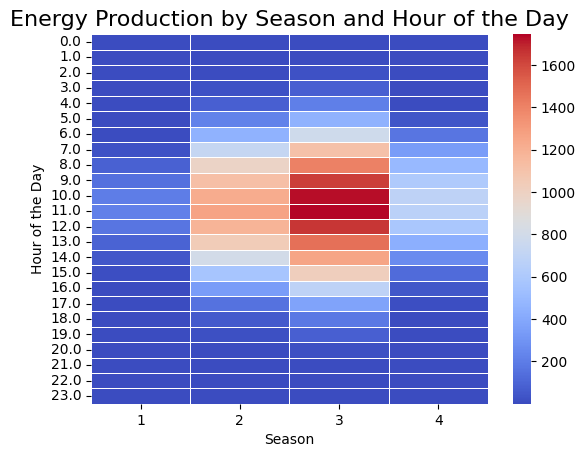

In [54]:
pivot_table = train.pivot_table(index='hour', columns='season', values='pv_measurement')

custom_cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(pivot_table, cmap=custom_cmap, fmt=".1f", linewidths=0.5)
plt.title('Energy Production by Season and Hour of the Day', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Hour of the Day')
plt.show()

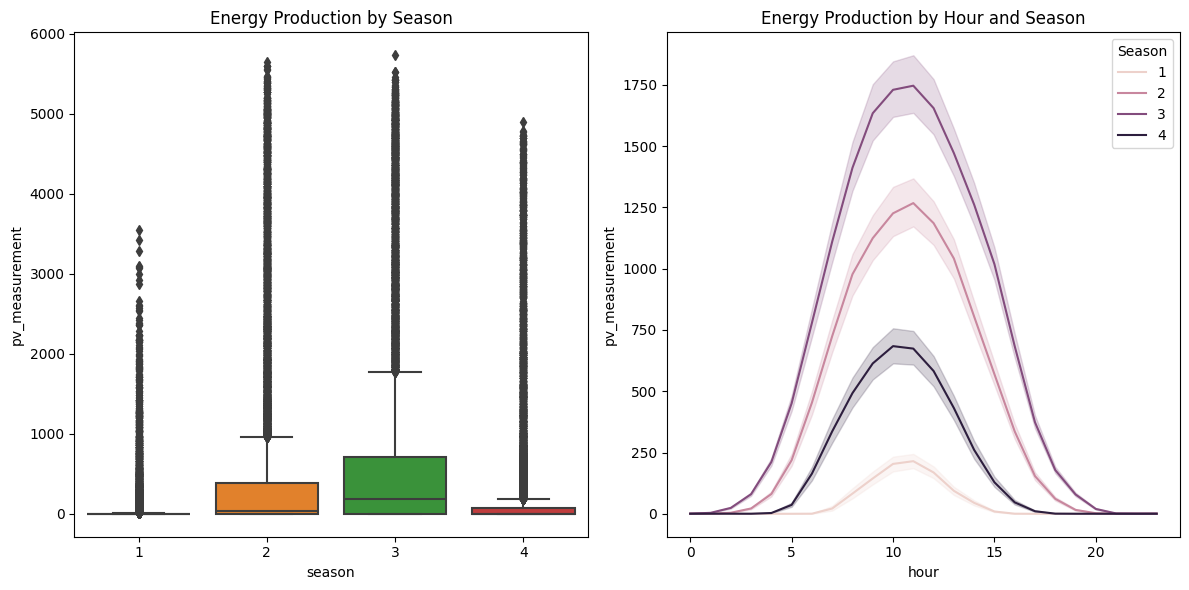

In [55]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='season', y='pv_measurement', data=train)
plt.title('Energy Production by Season')

plt.subplot(1, 2, 2)
sns.lineplot(x='hour', y='pv_measurement', hue='season', data=train)
plt.title('Energy Production by Hour and Season')
plt.legend(title='Season', loc='upper right')

plt.tight_layout()
plt.show()

In this lineplot the different values for 'pv_measurement' for A, B and C are plotted. A is really different from B and C, since its order of magnitude is bigger than the other two buildings.

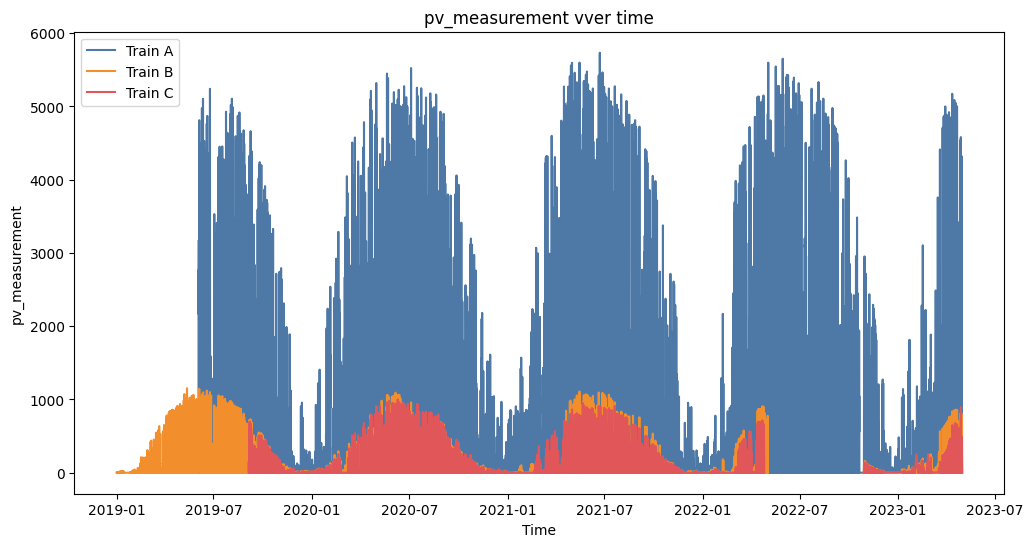

In [56]:
feature_name = 'pv_measurement'

plt.figure(figsize=(12, 6))
colors = ['#4E79A7', '#F28E2B', '#E15759']

plt.plot(train_a['time'], train_a[feature_name], label='Train A', color=colors[0])
plt.plot(train_b['time'], train_b[feature_name], label='Train B', color=colors[1])
plt.plot(train_c['time'], train_c[feature_name], label='Train C', color=colors[2])

plt.title(f'{feature_name} vver time')
plt.xlabel('Time')
plt.ylabel(feature_name)
plt.legend()
plt.show()

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79218 entries, 2019-06-02 22:00:00 to 2023-04-30 23:00:00
Data columns (total 55 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pv_measurement                  79218 non-null  float64
 1   absolute_humidity_2m:gm3        79218 non-null  float64
 2   air_density_2m:kgm3             79218 non-null  float64
 3   clear_sky_energy_1h:J           79218 non-null  float64
 4   clear_sky_rad:W                 79218 non-null  float64
 5   dew_or_rime:idx                 79218 non-null  float64
 6   dew_point_2m:K                  79218 non-null  float64
 7   diffuse_rad:W                   79218 non-null  float64
 8   diffuse_rad_1h:J                79218 non-null  float64
 9   direct_rad:W                    79218 non-null  float64
 10  direct_rad_1h:J                 79218 non-null  float64
 11  effective_cloud_cover:p         79218 non-null  float64
 1

## Explore single features, pairs and groups of features

The distribution of the y variable (merged for A, B and C) shows several periods in which the energy was not produced at all (or just in small quantities) and the more the values on the x axis slide towards the right, the frequency lowers increasingly.

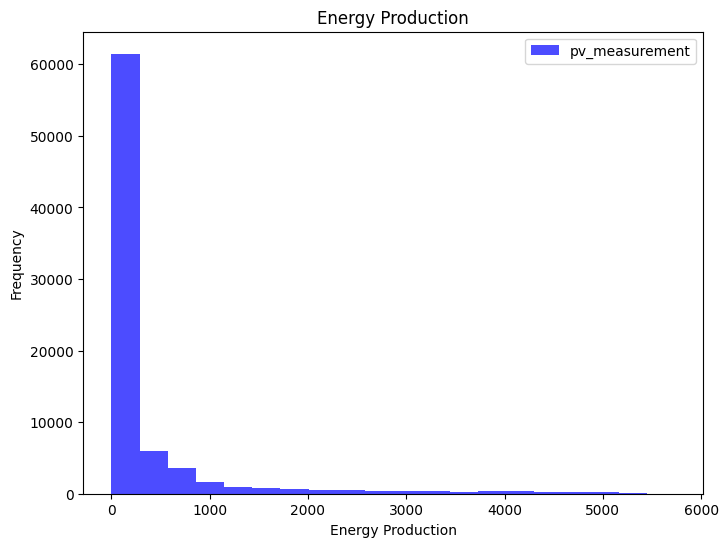

In [58]:
plt.figure(figsize=(8, 6))
plt.hist(train['pv_measurement'], bins=20, color='blue', alpha=0.7, label='pv_measurement')
plt.xlabel('Energy Production')
plt.ylabel('Frequency')
plt.legend()
plt.title('Energy Production')
plt.show()

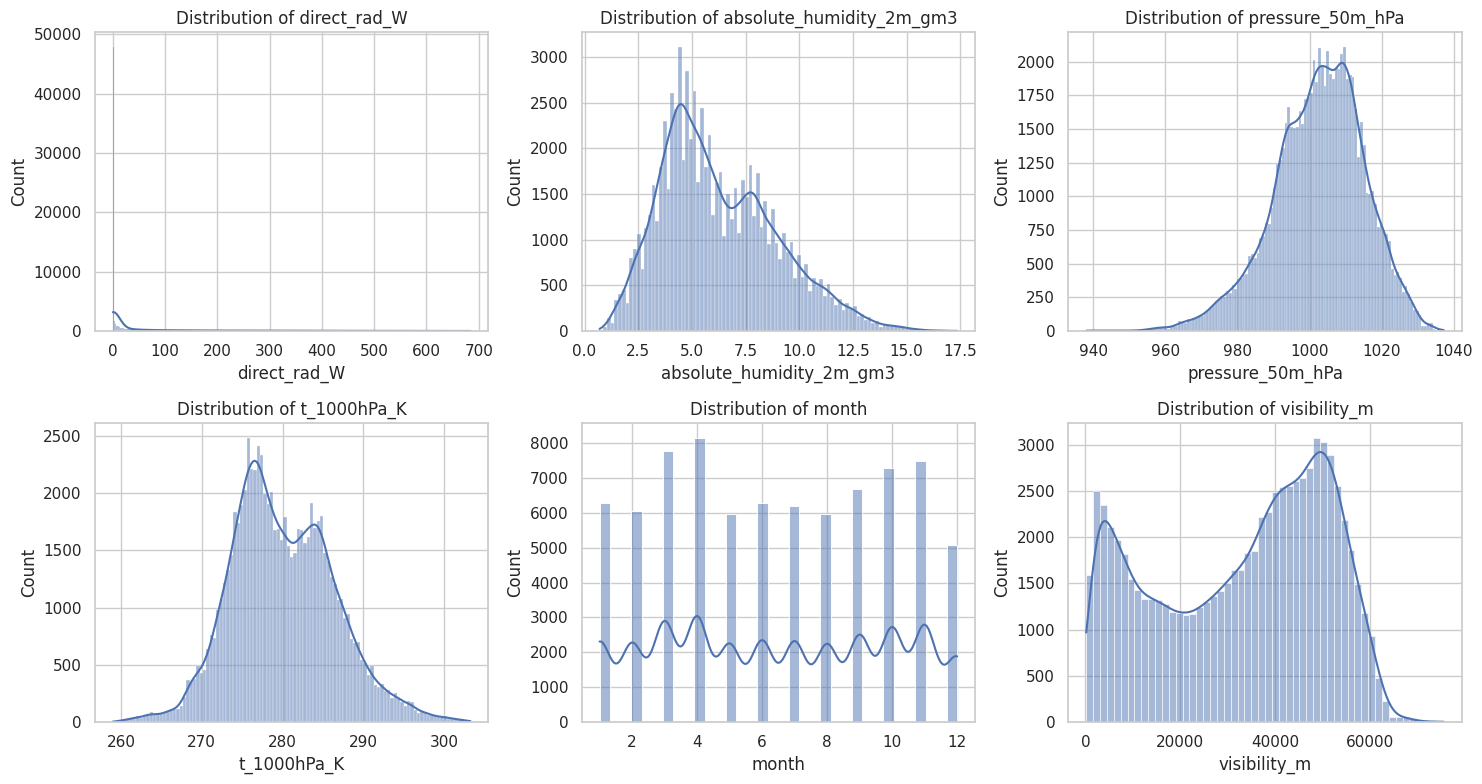

In [83]:
features = ['direct_rad_W', 'absolute_humidity_2m_gm3', 'pressure_50m_hPa', 't_1000hPa_K', 'month', 'visibility_m']
sns.set(style="whitegrid")
num_subplots = len(features)
fig, axes = plt.subplots(nrows=2, ncols=num_subplots // 2, figsize=(15, 8))

for i, col in enumerate(features):
    sns.histplot(X_train[col], ax=axes[i // (num_subplots // 2), i % (num_subplots // 2)], kde=True)
    axes[i // (num_subplots // 2), i % (num_subplots // 2)].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Here, it is possible to understand the relation between the following features:
- 'pv_measurement';
- 'direct_rad:W';
- 'absolute_humidity_2m:gm3';
- 'pressure_50m:hPa';
- 't_1000hPa:K'.

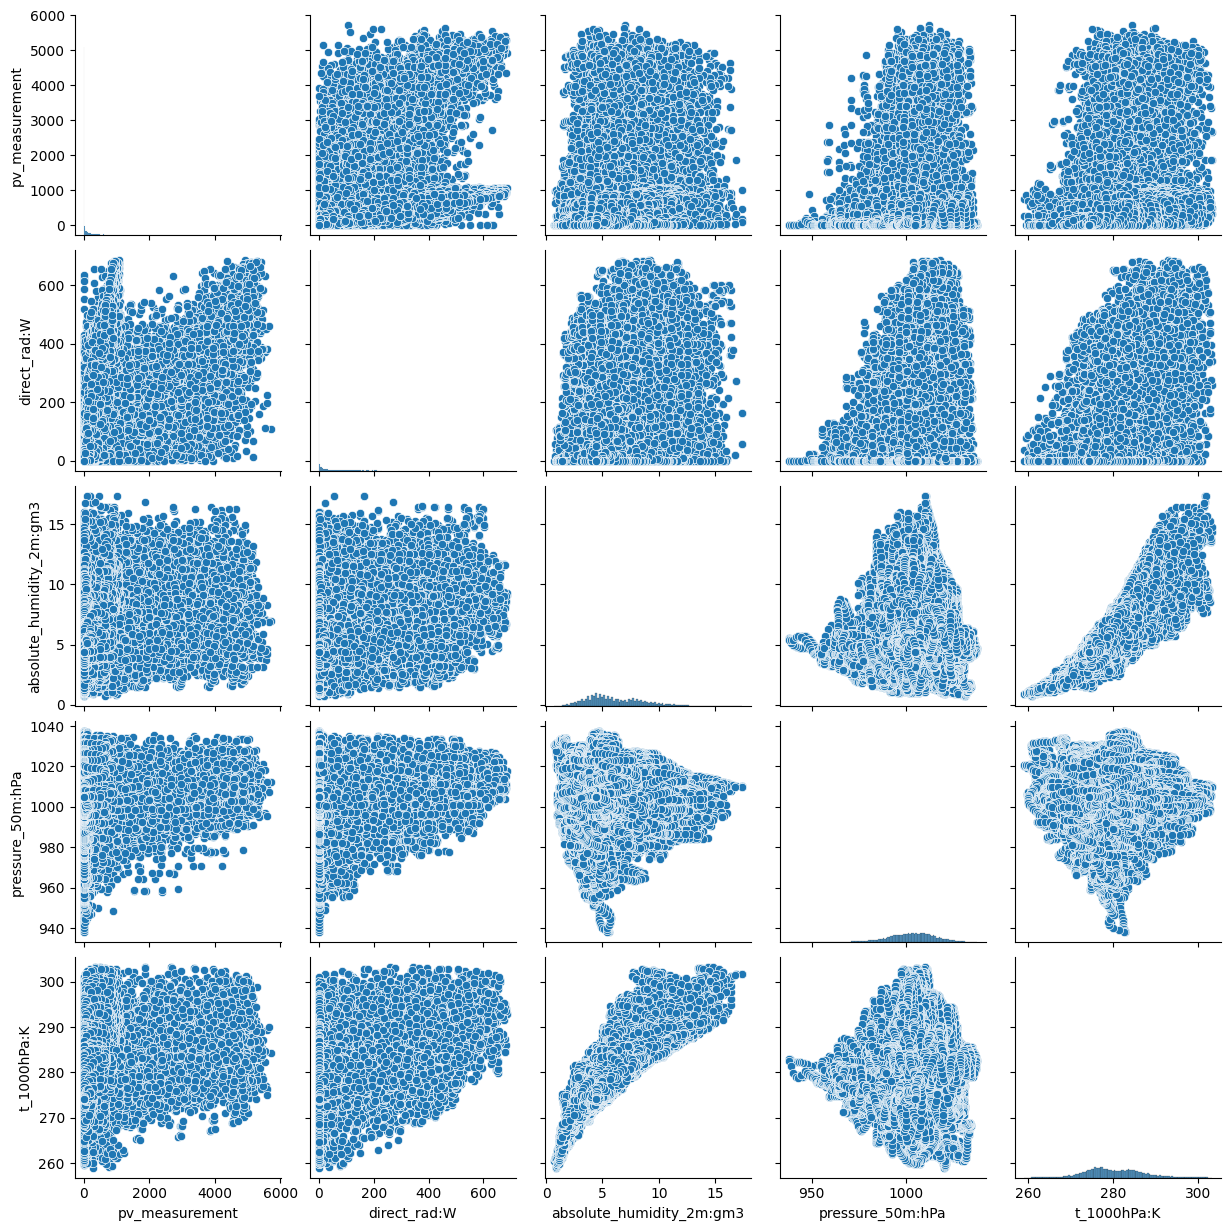

In [59]:
selected_features = ['pv_measurement', 'direct_rad:W', 'absolute_humidity_2m:gm3', 'pressure_50m:hPa', 't_1000hPa:K']
sns.pairplot(train[selected_features])
plt.show()

Here the correlation matrix of all the features of the training set. It is evident that the features involving the sun light (radiation, shadow position, etc.) are the ones influencing the most the 'pv_measurement' feature.

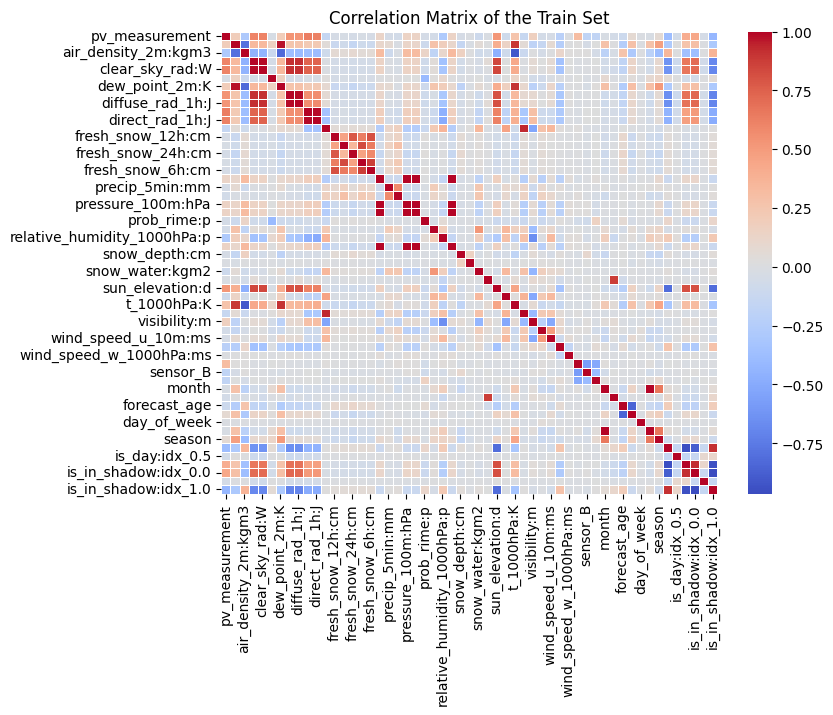

In [60]:
correlation_matrix = train.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of the Train Set')
plt.show()

## Preparation of the test set and the submission file base

In [61]:
X_test = test2.merge(test, left_on='time', right_on='date_forecast', how='left')
X_test = pd.get_dummies(X_test, columns=['location'], prefix='sensor2')

In [62]:
X_test = X_test[(X_test['sensor_A'] == X_test['sensor2_A']) &
                 (X_test['sensor_B'] == X_test['sensor2_B']) &
                 (X_test['sensor_C'] == X_test['sensor2_C'])]

In [63]:
del X_test['sensor2_A']
del X_test['sensor2_B']
del X_test['sensor2_C']

In [64]:
X_test = X_test.sort_values(by='id')

In [65]:
del X_test['id']
del X_test['prediction']

In [66]:
X_test=X_test.set_index('time')

In [67]:
test = test.rename_axis('time')
X_test = X_test.rename_axis('time')

In [68]:
X_train.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in X_train.columns]
X_test.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in X_test.columns]
test.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in test.columns]

## Additional feature engineering needed for some models

### Scaling the features

In [69]:
variances = X_train.var().sort_values()
pd.options.display.float_format = '{:.2f}'.format
print("Variances of all columns:")
print(variances)

Variances of all columns:
snow_melt_10min_mm                          0.00
wind_speed_w_1000hPa_ms                     0.00
precip_5min_mm                              0.00
air_density_2m_kgm3                         0.00
rain_water_kgm2                             0.00
fresh_snow_1h_cm                            0.01
super_cooled_liquid_water_kgm2              0.01
is_in_shadow_idx_0_5                        0.02
is_day_idx_0_5                              0.02
dew_or_rime_idx                             0.05
snow_water_kgm2                             0.05
fresh_snow_3h_cm                            0.06
precip_type_5min_idx                        0.10
is_obv                                      0.11
fresh_snow_6h_cm                            0.19
sensor_C                                    0.19
sensor_B                                    0.22
sensor_A                                    0.25
is_in_shadow_idx_0_0                        0.25
is_in_shadow_idx_1_0                       

In [73]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

### y_train transformation

In [74]:
y_train_transformed = np.sqrt(y_train) #Especially for LGBM

### Pairwise feature engineering

The following code has been used to identify the best interaction features, based on their improvement over MAE. It showed no actual improvement when the predictions were loaded to the Kaggle competition website.

In [ ]:
def creation_dataset_pairwise(dataset, feature_pd, num_new_features=-1):

    if num_new_features == -1:
        num_new_features = len(feature_pd)

    X_train_pairwise = dataset.copy()

    for i in range(num_new_features):
        feature1_name = feature_pd.iloc[i]['feature1']
        feature2_name = feature_pd.iloc[i]['feature2']
        combination_name = feature_pd.iloc[i]['combination']
        operation_name = feature_pd.iloc[i]['operation']
        X_train_pairwise[combination_name] = calculate_interaction(dataset, feature1_name, feature2_name, operation_name)

    return X_train_pairwise

In [ ]:
best_combinations=[1159, 75, 867, 1347, 3231, 2134, 3243, 526, 801, 27, 11, 127, 1118, 812,
                  138, 1323, 1910, 1718, 2175, 1419, 799, 1819, 2194, 1332, 809, 1414, 482, 583]
mask_bests_feat = unique_result[unique_result.index.isin(best_combinations)]
best_feat_pairwise = mask_bests_feat[0:len(best_combinations)-1]

In [ ]:
X_train_pairwise = creation_dataset_pairwise(X_train, best_feat_pairwise).copy()
X_test_pairwise = creation_dataset_pairwise(X_test, best_feat_pairwise).copy()

### Rolling features

In [ ]:
rolling_window = 7

X_train['rolling_direct_rad:W'] = X_train['direct_rad:W'].rolling(window=rolling_window).mean()
X_train['rolling_std_direct_rad:W'] = X_train['direct_rad:W'].rolling(window=rolling_window).std()
X_train['rolling_hour'] = X_train['hour'].rolling(window=rolling_window).mean()
X_train['rolling_std_hour'] = X_train['hour'].rolling(window=rolling_window).std()
X_test['rolling_direct_rad:W'] = X_test['direct_rad:W'].rolling(window=rolling_window).mean()
X_test['rolling_std_direct_rad:W'] = X_test['direct_rad:W'].rolling(window=rolling_window).std()
X_test['rolling_hour'] = X_test['hour'].rolling(window=rolling_window).mean()
X_test['rolling_std_hour'] = X_test['hour'].rolling(window=rolling_window).std()

The following functions create some rolling features based on some existing features selected by us.

In [ ]:
def transformation_rolling(X_train, y_train=None):
    X_train_roll = X_train.copy()
    if y_train is not None:
        y_train_roll = y_train.copy()

    X_train_roll['prev_24_directrad'] = X_train['direct_rad_W'].shift(24, freq='H')
    X_train_roll['succ_24_directrad'] = X_train['direct_rad_W'].shift(-24, freq='H')
    
    X_train_roll=X_train_roll.reset_index()
    if y_train is not None:
        y_train_roll=y_train_roll.reset_index()
    if y_train is not None:
        X_train_roll = X_train_roll.dropna()  # Rimuovi le righe che contengono valori mancanti
    if y_train is not None:
        y_train_roll = y_train_roll.iloc[X_train_roll.index]
    X_train_roll.set_index('time',inplace=True)
    if y_train is not None:
        y_train_roll.set_index('time',inplace=True)
    if y_train is not None:
        return X_train_roll,y_train_roll
    return X_train_roll

In [ ]:
def rolling(X_train, y_train, X_test, model, params=0):
    if params == 0:
        params = dict_model_param[model]
    
    Xy_train = X_train.copy()
    Xy_test = X_test.copy()
    
    Xy_train['pv_measurement']=y_train
    Xy_train_A = Xy_train[Xy_train['sensor_A'] == 1]
    Xy_train_B = Xy_train[Xy_train['sensor_B'] == 1]
    Xy_train_C = Xy_train[Xy_train['sensor_C'] == 1]
    
    Xy_test_A = Xy_test[Xy_test['sensor_A'] == 1]
    Xy_test_B = Xy_test[Xy_test['sensor_B'] == 1]
    Xy_test_C = Xy_test[Xy_test['sensor_C'] == 1]
    
    _,pred_base = prediction_models(X_train, 
                                    y_train, 
                                    X_test,
                                    model, 
                                    params)
    
    pred_base = pred_to_df(pred_base)

    X_train_roll=[]
    y_train_roll=[]
    X_test_roll=[]
    
    for train in [Xy_train_A, Xy_train_B, Xy_train_C]:
        X_train_roll_a, y_train_roll_a = transformation_rolling(train[predictors], train['pv_measurement'])
        X_train_roll.append(X_train_roll_a)
        y_train_roll.append(y_train_roll_a)
        
    X_train_roll= pd.concat(X_train_roll)    
    y_train_roll= pd.concat(y_train_roll)
    
    for test in [Xy_test_A, Xy_test_B, Xy_test_C]:
        X_test_roll_a = transformation_rolling(test[predictors])
        X_test_roll.append(X_test_roll_a)
        
    X_test_roll=pd.concat(X_test_roll)
        
    mask_nan = X_test_roll.isna().any(axis=1)
    X_test_roll = X_test_roll.fillna(0)
    
    _,pred_rolling = prediction_models(X_train_roll, y_train_roll, X_test_roll, model, params=0)
    pred_rolling = np.where(mask_nan==True, pred_base['values'], pred_rolling)

    return pred_to_df(pred_rolling)

### Feature Selection and Feature Importance

#### First Attempt, automatic feature selection

The following code has been used but didn't show any result.

In [ ]:
print(sys.path)
sys.path.append('d:\\anaconda3\\envs\\solarenergy\\lib\\site-packages')
from featurewiz import featurewiz
np.random.seed(0)

arget = 'pv_measurement'
 
features, wiz_train = featurewiz(train.iloc[:,1:], target, corr_limit=0.7, verbose=0, sep=",",
header=0,test_data="", feature_engg="", category_encoders="")

#### Second Attempt, feature importance by mutual info regression

<Axes: >

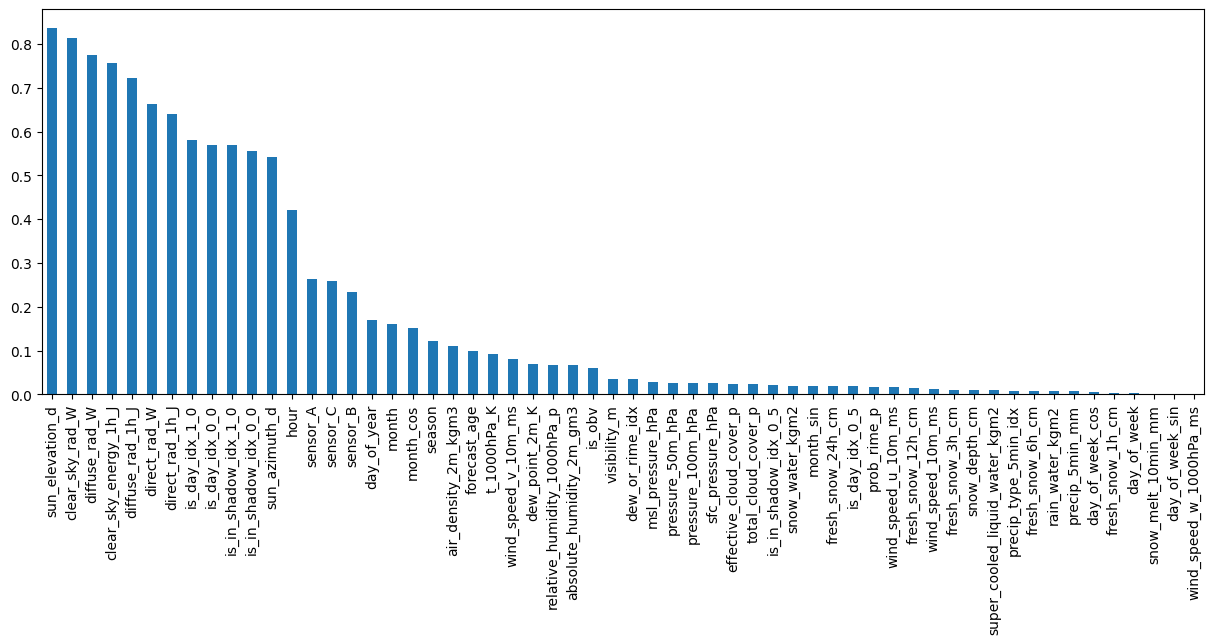

In [75]:
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

## Feature engineering explained

In the previous sections, some feature engineering has been done.

Here explained all the processes that the group has decided to do and thought it was the best procedure to implement:

- *One-Hot Encoding* to convert the categorical variables into binary vectors. This has been done for the variables 'is_day:idx' and 'is_in_shadow:idx';
- *Feature Scaling* to standardize the numerical features. In this case, the StandardScaler method has been executed both on the training and the test set for the xgboost model;
- *Transformation of the y_train*, which has been used for the light gbm model. The squared root of the y_train feature has been taken and used to train the model and predicting the y_test; before submitting the predictions, the operation "y_test**2" has been carried out;
- *Date and time features* such as 'month', 'hour', 'season', 'day_of_week' and some sin and cos features of the temporal ones;
- *Interaction features* thanks to the pairwise function which helped to decide which interaction features were the most useful;
- *Feature selection and Feature importance*;
- *Rolling features* to improve the performance of the model.

It has been decided to keep all the features and not to drop them, except for the ones with several NaN values such as 'snow_density:kgm3', 'ceiling_height_agl:m', 'snow_drift:idx', 'elevation:m', 'cloud_base_agl:m'.

## Attempt 1

The first attempt that the group has tried, was the model xgboost.

In [86]:
tscv_train = TimeSeriesSplit(n_splits=5)

xgb_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 1000,
    'subsample': 0.8
}

validation_metrics = []
feature_importance_list = []

for train_index, test_index in tscv_train.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(X_train_fold, y_train_fold)

    val_mae = mean_absolute_error(y_val_fold, xgb_model.predict(X_val_fold))
    validation_metrics.append(val_mae)

    feature_importance = xgb_model.feature_importances_
    feature_importance_list.append(feature_importance)

mean_feature_importance = sum(feature_importance_list) / len(feature_importance_list)

In [97]:
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')

feature_importance_list = [(feature, score) for feature, score in feature_importance.items()]

feature_importance_list = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

for feature, importance in feature_importance_list:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: sensor_A, Importance: 3076.0
Feature: direct_rad_W, Importance: 2551.0
Feature: diffuse_rad_W, Importance: 1919.0
Feature: clear_sky_rad_W, Importance: 1570.0
Feature: t_1000hPa_K, Importance: 1160.0
Feature: day_of_year, Importance: 1142.0
Feature: direct_rad_1h_J, Importance: 1128.0
Feature: diffuse_rad_1h_J, Importance: 1124.0
Feature: wind_speed_u_10m_ms, Importance: 1100.0
Feature: sun_azimuth_d, Importance: 1054.0
Feature: absolute_humidity_2m_gm3, Importance: 939.0
Feature: clear_sky_energy_1h_J, Importance: 917.0
Feature: wind_speed_v_10m_ms, Importance: 862.0
Feature: visibility_m, Importance: 848.0
Feature: sun_elevation_d, Importance: 845.0
Feature: msl_pressure_hPa, Importance: 792.0
Feature: air_density_2m_kgm3, Importance: 773.0
Feature: effective_cloud_cover_p, Importance: 772.0
Feature: wind_speed_10m_ms, Importance: 741.0
Feature: total_cloud_cover_p, Importance: 691.0
Feature: relative_humidity_1000hPa_p, Importance: 684.0
Feature: dew_point_2m_K, Importance:

In [90]:
xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train_scaled, y_train)

pred=xgb_model.predict(X_test_scaled)

In [91]:
pred = pred_to_df(pred)
pred

,values
id,
0,0.00
1,0.00
2,0.00
3,55.24
4,363.10
...,...
2155,30.59
2156,18.16
2157,0.00


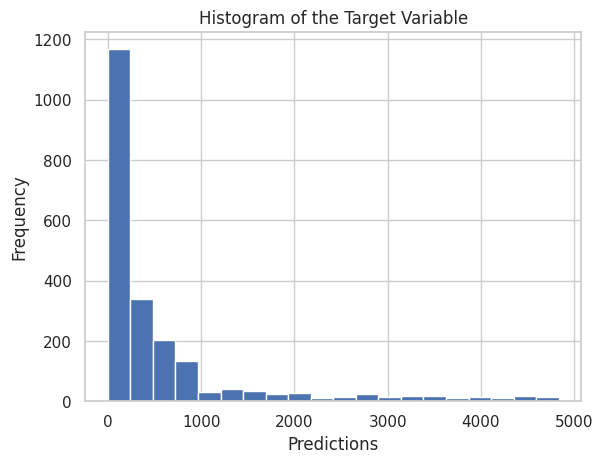

In [92]:
plt.hist(pred, bins=20)
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.title('Histogram of the Target Variable')
plt.show()

## Attempt 2

The second attempt that the group has tried, was the model light gbm.

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)

train_data = lgb.Dataset(X_train, label=y_train_transformed)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'feature_pre_filter':True,
    'bagging_freq': 5,
    'bagging_fraction': 0.75
}

num_round = 1000
lgb_model = lgb.train(params, train_data, num_round)

pred = lgb_model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:
pred = pred_to_df(pred, squared=True)
pred

### Model interpretation

In [ ]:
plt.hist(pred, bins=20)
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.title('Histogram of the Target Variable')
plt.show()

## Attempt 3

The third attempt that the group has tried, was the model randomforest.

In [ ]:
rf_model = RandomForestRegressor(n_estimators=1000,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_features='sqrt',
                                max_depth=25)

In [ ]:
weights = np.where(X_train['is_obv'] == 0, 8.0, 1.0)

In [ ]:
rf_model.fit(X_train, y_train, weights)

In [ ]:
pred = rf_model.predict(X_test[X_train.columns])

In [ ]:
pred = pred_to_df(pred)
pred

In [ ]:
plt.hist(pred, bins=20)
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.title('Histogram of the Target Variable')
plt.show()

## Other attempts

Before running the final model, other experiments have been carried out such as:
- KNN
- Prophet
- SVR
- Linear Regression
- H2O AutoML

## Final attempt

### Y_slided

This algorithm is used to make the predictions and it considers a new feature: the pv_measurement measured the hour before. During the test phase, pv_measurement are firstly predicted hour by hour and at every prediction, the pv_measurement needed will be inserted in the features in order to predict the next one.

For example:
If we have three hourly time slots, each time slot will be tested with the previous pv_measurement and so on. The first observation will not follow this pattern, but will be predicted with another model that uses standard features.

- date1 feat1 feat2 -> pv_measurement_pred_date1
- date2 feat1 feat2 pv_measurement_pred_date1 -> pv_measurement_pred_date2
- date3 feat1 feat2 pv_measurement_pred_date2 -> pv_measurement_pred_date3

In [ ]:
def y_slided_prediction(X_train, y_train, test=test, model='lgbm', params=0, squared=False):
    if params==0:
        params = dict_model_param[model]

    Xy_train = X_train.copy()
    Xy_train['pv_measurement'] = y_train

    Xy_train_A = Xy_train[Xy_train['sensor_A'] == 1]
    Xy_train_B = Xy_train[Xy_train['sensor_B'] == 1]
    Xy_train_C = Xy_train[Xy_train['sensor_C'] == 1]

    Xy_train_A['previous_pv_measurement'] = Xy_train_A['pv_measurement'].shift(1, freq='H')
    Xy_train_B['previous_pv_measurement'] = Xy_train_B['pv_measurement'].shift(1, freq='H')
    Xy_train_C['previous_pv_measurement'] = Xy_train_C['pv_measurement'].shift(1, freq='H')

    X_train_y_slided = pd.concat([Xy_train_A, Xy_train_B, Xy_train_C])
    X_train_y_slided.dropna()
    y_train_y_slided = X_train_y_slided['pv_measurement']
    X_train_y_slided.drop(columns=['pv_measurement'], inplace=True)

    y_train_transformed = np.sqrt(y_train_y_slided) if squared else y_train_y_slided

    _,y_pred = prediction_models(X_train, y_train_transformed, test=test, model=model) #predizione non slided
    
    pred = pred_to_df(y_pred, squared)
    
    model2 = prediction_models(X_train_y_slided, y_train_y_slided, model=model)
    
    test_slide_A = test[test['sensor_A'] == 1]
    test_slide_B = test[test['sensor_B'] == 1]
    test_slide_C = test[test['sensor_C'] == 1]
    
    range2 = len(pred)
    range3 = range2 * 2
    
    
    pred_A = pred[:len(test_slide_A)-1]
    pred_B = pred[len(test_slide_A):len(test_slide_B)+len(test_slide_A)-1]
    pred_C = pred[len(test_slide_B)+len(test_slide_A):]
    
    datasets = [test_slide_A, test_slide_B, test_slide_C]
    preds = [pred_A, pred_B, pred_C]

    result_all = []

    for i in [0, 1, 2]:

        dataset = datasets[i]
        pred_set = preds[i]

        result = []
        previous_pv_measurement = pred.values[0][0]

        result.append(previous_pv_measurement)
        max_time_diff = pd.Timedelta(hours=1)

        test_copy = dataset.copy()
        test_copy['previous_pv_measurement'] = 0

        for index in range(1, len(dataset)):
            if test_copy.index[index] - test_copy.index[index-1] > max_time_diff:
                previous_pv_measurement = pred_set.values[index][0]
            else:
                test_copy.loc[test_copy.index[index], 'previous_pv_measurement'] = previous_pv_measurement
                if model=='lgbm':
                    previous_pv_measurement = model2.predict(test_copy.iloc[index], num_iteration=model2.best_iteration)[0]
                else:
                    previous_pv_measurement = model2.predict(np.array(test_copy.iloc[index]).reshape(1, 59))[0]
                    
            result.append(previous_pv_measurement)

        result_all.append(result)
        
    flattened_list = [item for sublist in result_all for item in sublist]
    return pred_to_df(pd.DataFrame(flattened_list), False)

### Hyperparameter tuning

In order to optimize the parameters, the group runned the following hyperparameter tuning: the Bayesian Optimization has been chosen, even if also the GridSearch method has been tried out.

#### Attempt with GridSearch for XGBoost

In [ ]:
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}
grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)

In [ ]:
grid_search.fit(X_train_scaled_a, y_train_a)

#### Bayesian Optimization LGBMRegressor

In [ ]:
def objective(params):
    lgbm_params = {
        'learning_rate': params[0],
        'n_estimators': int(params[1]),
        'max_depth': int(params[2]),
        'min_child_samples': int(params[3]),
        'feature_fraction': params[4],
        'bagging_fraction': params[5],
        'reg_alpha': params[6],
        'reg_lambda': params[7],
        'min_split_gain': params[8],
        'max_bin': int(params[9]),
        'min_child_weight': params[10]
    }

    model = LGBMRegressor(**lgbm_params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    return -scores.mean()

In [ ]:
param_space = [
    space.Real(0.01, 0.1, name='learning_rate'),
    space.Integer(50, 500, name='n_estimators'),
    space.Integer(3, 15, name='max_depth'),
    space.Integer(2, 100, name='min_child_samples'),
    space.Real(0.6, 1.0, name='feature_fraction'),
    space.Real(0.6, 1.0, name='bagging_fraction'),
    space.Real(0.01, 1.0, name='reg_alpha'),
    space.Real(0.01, 1.0, name='reg_lambda'),
    space.Real(0.0, 0.5, name='min_split_gain'),
    space.Integer(20, 200, name='max_bin'),
    space.Real(0.0, 1.0, name='min_child_weight'),
    space.Integer(10, 500, name='subsample_for_bin')
]
result = gp_minimize(objective, param_space, n_calls=10, random_state=42, verbose=True)

In [ ]:
best_params = {
    'learning_rate': result.x[0],
    'n_estimators': int(result.x[1]),
    'max_depth': int(result.x[2]),
    'min_child_samples': int(result.x[3]),
    'feature_fraction': result.x[4],
    'bagging_fraction': result.x[5],
    'reg_alpha': result.x[6],
    'reg_lambda': result.x[7],
    'min_split_gain': result.x[8],
    'max_bin': int(result.x[9]),
    'min_child_weight': result.x[10],
    'subsample_for_bin': int(result.x[11])
}

best_params

#### Bayesian Optimization Catboost

In [ ]:
X, y = X_train.copy(), y_train_transformed.copy()

param_space = {
    'iterations': (50, 5000),
    'depth': (1, 12),
    'learning_rate':  (0.01, 1.0)
}

catboost = CatBoostRegressor(loss_function='MAE')

opt = BayesSearchCV(
    catboost,
    param_space,
    n_iter=10,
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=True
)

opt.fit(X, y)

print("Best hyperparameters:", opt.best_params_)
print("Best ROC-AUC score:", opt.best_score_)

In [ ]:
opt.best_params_

#### Bayesian Optimization Random Forest

In [ ]:
def rf_opt(X, y):
    param_space = {
        'n_estimators': (10, 200),
        'max_depth': (2, 32),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 10),
        'max_features': (0.1, 1.0)
    }

    rf = RandomForestRegressor()

    opt = BayesSearchCV(
        rf,
        param_space,
        n_iter=15,
        cv=5,
        n_jobs=-1, 
        random_state=42,
        verbose=True
    )

    opt.fit(X, y)

    print("Best hyperparameters:", opt.best_params_)
    print("Best score:", opt.best_score_)

    return opt.best_params_

In [ ]:
best_params = rf_opt(X_train, y_train_transformed)
best_params

#### Bayesian Optimization XGBoost

In [ ]:
def xgboost_opt(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def objective(params):
        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)

        return {'loss': mse, 'status': STATUS_OK}

    space = {
        'n_estimators': hp.quniform('n_estimators', 10, 1000, 1),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.loguniform('learning_rate', -5, 0),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
    }

    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

    print("Best Hyperparameters:")
    print(best)

#### Final parameters

In [ ]:
dict_model_param = {
    'lgbm': {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.01,
        'feature_fraction': 0.7,
        'feature_pre_filter': True,
        'bagging_freq': 5,
        'bagging_fraction': 0.75
    },
    'lgbm_reg': {
        'learning_rate': 0.07019571273972466,
        'n_estimators': 350,
        'max_depth': 10,
        'min_child_samples': 29,
        'feature_fraction': 0.8244973703390805,
        'bagging_fraction': 0.753170749901516,
        'reg_alpha': 0.9719949744352129,
        'reg_lambda': 0.8504246860234232,
        'min_split_gain': 0.36086476058243666,
        'max_bin': 62,
        'min_child_weight': 0.256068322761324,
        'subsample_for_bin': 30
    },
    'catboost': {
        'iterations': 1000, 
        'depth': 6, 
        'learning_rate': 0.1, 
        'loss_function': 'MAE'
    },
    'catboost2': {
        'depth': 10,
        'iterations': 1018,
        'l2_leaf_reg': 2.2212618063028153,
        'learning_rate': 0.2985693064115024
    },
    'catboost_opt': {
        'depth': 6,
        'iterations': 4598,
        'learning_rate': 0.11381056696717655
    },
    'xgboost' : {
        'colsample_bytree': 0.8,
        'learning_rate': 0.01,
        'max_depth': 5,
        'n_estimators': 1000,
        'subsample': 0.8
    },
    'xgboost2' : {
        'colsample_bytree': 0.70468596253168,
        'learning_rate': 0.00931602383319447,
        'max_depth': 7,
        'n_estimators': 56,
        'subsample': 0.9610097364456339
    },
    'xgboost3':{
        'colsample_bytree': 0.7224776657906091,
        'learning_rate': 0.044779531399174476,
        'max_depth': 10,
        'n_estimators': 906,
        'subsample': 0.706461320142151
    },
    'randomforest' :{
        'n_estimators': 1000,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'max_depth': 25
    },
    'randomforest_opt' :{
        'max_depth': 26,
        'max_features': 0.4942262677968311,
        'min_samples_leaf': 6,
        'min_samples_split': 8,
        'n_estimators': 1809
    }
}

### Preparation of the models

In [ ]:
def pred_lgbm_reg(X_train, y_train, test=None, params=0, weights=None):
    if params is None:
        params = dict_model_param['lgbm_reg']

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model = LGBMRegressor(**params)

    eval_set = [(X_val, y_val)]

    model.fit(X_train, y_train, eval_set=eval_set)

    if test is not None:
        predictions = model.predict(test)

        return model, predictions

    return model

In [ ]:
def pred_xgboost(X_train, y_train, test=None, params=0):
    
    if params ==0:
        params = dict_model_param['xgboost']
    
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42) 
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    if test is not None:
        predictions = model.predict(X_test)

        return model, predictions
    
    return model

In [ ]:
def pred_randomforest(X_train, y_train, test=None, params=0):
    
    if params ==0:
        params = dict_model_param['randomforest']
    
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    if test is not None:
        predictions = model.predict(X_test)

        return model, predictions
    
    return model

In [ ]:
def prediction_models(X_train, y_train, test=None, model='lgbm', params=None, weights=None):#, cat_features=0):
    if weights is None:
        weights = [1]*len(X_train)
    if model=='lgbm':
        return pred_lgbm(X_train, y_train, test, params, weights)
    if model=='catboost':
        return pred_catboost(X_train, y_train, test, params)
    if model=='xgboost':
        return pred_xgboost(X_train, y_train, test, params)
    if model=='randomforest':
        return pred_randomforest(X_train, y_train, test, params)
    if model=='lgbm_reg':
        return pred_lgbm_reg(X_train, y_train, test, params)

### Models Predictions

In [ ]:
result_lgbm_slided = y_slided_prediction(X_train, y_train_transformed, test=test, model='lgbm', params=dict_model_param['lgbm'])

In [ ]:
result_lgbm_slided = pred_to_df(result_lgbm_slided, squared= True)

In [ ]:
result_lgbm_r_slided = y_slided_prediction(X_train, y_train, test=test, model='lgbm_reg', squared=False)

In [ ]:
lgbm,result_lgbm = prediction_models(X_train, y_train_transformed, test=X_test, model='lgbm')

In [ ]:
result_lgbm = pred_to_df(result_lgbm, squared=True)

### Models Validations

In [ ]:
def validation_lgbm(X, y, params=0, n_splits=5):
    if params == 0 :
        params = dict_model_param['lgbm']
    train_data = lgb.Dataset(X, label=y)
    mae_scores = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        model = lgb.train(params, train_data, num_boost_round=1000)
        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
        mae = mean_absolute_error(y_val, y_pred)
        mae_scores.append(mae)
    average_mae = np.mean(mae_scores)
    return average_mae

In [ ]:
def validation_catboost(X, y, params=0, n_splits=5):
    
    dataset = Pool(data=X, label=y)
    
    if params == 0 :
        params = dict_model_param['catboost']
    mae_scores = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model, y_pred = prediction_models(X_train, y_train, X_val, 'catboost', params)
        
        mae = mean_absolute_error(y_val, y_pred)
        mae_scores.append(mae)

    average_mae = np.mean(mae_scores)
    return average_mae

In [ ]:
def validation_xgboost(X, y, params=0, n_splits=5):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)

    if params == 0 :
        params = dict_model_param['xgboost']

    mae_scores = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model, y_pred = prediction_models(X_train, y_train, X_val, 'xgboost', params)
    
        mae = mean_absolute_error(y_val, y_pred)
        mae_scores.append(mae)
    average_mae = np.mean(mae_scores)
    return average_mae

In [ ]:
def validation_randomforest(X, y, params=0, n_splits=5):
    if params == 0 :
        params = dict_model_param['randomforest']
    
    mae_scores = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model, y_pred = prediction_models(X_train, y_train, X_val, 'randomforest', params)
        
        mae = mean_absolute_error(y_val, y_pred)
        mae_scores.append(mae)
    average_mae = np.mean(mae_scores)
    return average_mae

In [ ]:
def validation_lgbm_reg(X, y, params=0, n_splits=5):
    if params == 0 :
        params = dict_model_param['lgbm_reg']
        
    train_data = lgb.Dataset(X, label=y)

    mae_scores = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = LGBMRegressor(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
       
        mae = mean_absolute_error(y_val, y_pred)
        mae_scores.append(mae)   

    average_mae = np.mean(mae_scores)
    return average_mae

In [ ]:
def validation(model, X, y, params=0, n_splits=5):
    if model=='lgbm':
        return validation_lgbm(X, y, params, n_splits)
    if model=='catboost':
        return validation_catboost(X, y, params, n_splits)
    if model=='xgboost':
        return validation_xgboost(X, y, params, n_splits)
    if model=='randomforest':
        return validation_randomforest(X, y, params, n_splits)
    if model=='lgbm_reg':
        return validation_lgbm_reg(X, y, params, n_splits)

### Stacking

In [ ]:
def stacking_models(base_models, X_train, y_train, test=None, final_regressor='linear', final_params={}):
    if final_regressor=='linear':
        final_model = LinearRegression()
    elif final_regressor == 'SVR':
        final_model = SVR(**final_params)
        
    stacking_regressor = StackingRegressor(
        estimators=base_models,
        final_estimator=final_model)
    
    stacking_regressor.fit(X_train, y_train)

    if X_test is not None:
        y_pred = stacking_regressor.predict(X_test)
        return stacking_regressor, y_pred
    else:
        return stacking_regressor

#### Stacking 1

In [ ]:
lgbm, lgb_pred = prediction_models(X_train, y_train_transformed, test=X_test, model='lgbm_reg', params=None)
lgb_pred = pred_to_df(lgb_pred, squared=True)

In [ ]:
catboostm, catboost_pred = prediction_models(X_train, y_train_transformed, test=X_test, model='catboost', params=dict_model_param['catboost'])
catboost_pred = pred_to_df(catboost_pred, squared=True)

In [ ]:
xgboost, xgboost_pred = prediction_models(X_train, y_train_transformed, test=X_test, model='xgboost', params=dict_model_param['xgboost2'])
xgboost_pred = pred_to_df(xgboost_pred, squared=True)

In [ ]:
randomforest, randomforest_pred = prediction_models(X_train, y_train_transformed, test=X_test, model='randomforest', params=dict_model_param['randomforest_opt'])
randomforest_pred = pred_to_df(randomforest_pred, squared=True)

In [ ]:
base_models = [
    ('lgbm', lgbm),
    ('catboost', catboostm),
    ('randomforest', randomforest)
]
final_model_1, final_pred_1 = stacking_models(base_models,
                                          X_train, y_train_transformed,
                                          test=X_test, final_regressor='linear',
                                          final_params={})

In [ ]:
final_pred_1_2 = pred_to_df(final_pred_1, squared=True)

#### Stacking 2

In [ ]:
base_models_2 = [
    ('lgbm', lgbm),
    ('catboost', catboostm),
    ('xgboost', xgboost),
    ('randomforest', randomforest)
]
final_model_2, final_pred_2 = stacking_models(base_models_2, 
                                              X_train, y_train_transformed, 
                                              test=X_test, final_regressor='linear', 
                                              final_params={})

In [ ]:
final_pred_2_2 = pred_to_df(final_pred_2, squared=True)

#### Stacking 3

In [ ]:
catboostm2, _ = prediction_models(X_train, y_train_transformed, test=X_test, model='catboost', params=dict_model_param['catboost_opt'])

In [ ]:
xgboost2, _ = prediction_models(X_train, y_train_transformed, test=X_test, model='xgboost', params=dict_model_param['xgboost3'])

In [ ]:
base_models_3 = [
    ('lgbm', lgbm),
    ('catboost', catboostm),
    ('catboost2', catboostm2),
    ('xgboost', xgboost2)
]
final_model_3, final_pred_3 = stacking_models(base_models_3,
                                                X_train, y_train_transformed,
                                                test=X_test, final_regressor='SVR', 
                                                final_params={})

In [ ]:
final_pred_3_2 = pred_to_df(final_pred_3, True)

### Model Interpretation

- The feature importance helped understanding the difference between all the models:
    - For example, some models showed that 'sensor_A' variable was really important for them, which means that the model confirmed the assumptions about the different extension of the panel coverage of the three buildings (as seen in the previous graph of the energy production 'pv_measurement').
- Thanks to the validation operation, it was easy to understand how the models worked (including some plotting):
    - For example, looking at the results of the predicted 'pv_measurement', it was possible to notice that some models underestimated the production (especially during the moments of maximum energy production). This helped in defining better model results.


### Postprocessing

In [ ]:
merge1 = merge_with_slided_A(result_lgbm, result_lgbm_slided)

In [ ]:
merge2 = merge_with_slided_A(merge1, result_lgbm_r_slided)

In [ ]:
merge3 = merge_with_slided(final_pred_1_2, merge2)

In [ ]:
merge3_1 = merge_with_slided(final_pred_2_2, merge2)

In [ ]:
#AVG of two models for the first submission
result_column = (merge3['values'] + merge3_1['values']) / 2

avg1 = pd.DataFrame({'Mean_Value': result_column})
avg1 = pred_to_df(avg1)

In [ ]:
avg2 = pd.DataFrame()
avg2['val1'] = avg1['values'] 
avg2['val2'] = final_pred_3_2['values']
avg2['avg'] = (avg2['val1'] + avg2['val2'] * 2)/3
avg2['values'] = np.where(avg2['val1'] > 2000, avg2['val1'], avg2['avg'])
avg2 = avg2.drop(columns=['val1','val2','avg'])
avg2= pred_to_df(avg2)
avg2.to_csv('short_notebook_1_submission.csv')

In [ ]:
#AVG of two models for the second submission
result_column = (merge3['values'] + merge3_1['values']) / 2

avg1 = pd.DataFrame({'Mean_Value': result_column})
avg1 = pred_to_df(avg1)

In [ ]:
avg2 = pd.DataFrame()
avg2['val1'] = avg1['values'] 
avg2['val2'] = final_pred_3_2['values']
avg2['avg'] = (avg2['val1']*2 + avg2['val2'])/3
avg2['values'] = np.where(avg2['val1'] > 2000, avg2['val1'], avg2['avg'])
avg2 = avg2.drop(columns=['val1','val2','avg'])
avg2= pred_to_df(avg2)
avg2.to_csv('short_notebook_2_submission.csv')